In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## Loading Data

In [2]:
import pickle
with open('Processed_data_RGB_224x224.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
Features = np.stack(data['image'].values)
Target = data['label']

## Splitting Data

In [6]:
x_train, x_test, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)

In [7]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [8]:
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

## Loading EfficientNetB7 Model

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras.preprocessing import image

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


In [10]:
model = models.Sequential([
    base_model,
    layers.MaxPooling2D(),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functiona  (None, 7, 7, 2560)        64097680  
 l)                                                              
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 2560)        0         
 D)                                                              
                                                                 
Total params: 64097680 (244.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 64097680 (244.51 MB)
_________________________________________________________________


In [13]:
features = model.predict(x_train)
x_test_features = model.predict(x_test)

32/32 [==============================] - 49s 2s/step


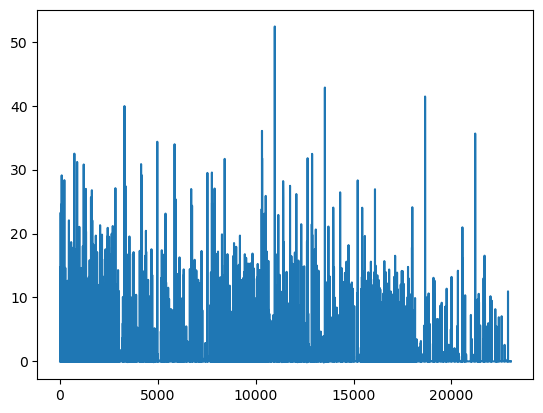

In [14]:
features = features.reshape((features.shape[0], -1))
x_test_features = x_test_features.reshape((x_test_features.shape[0], -1))
plt.plot(features[121])

In [15]:
features.shape

(2389, 23040)

## KNN Classifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [18]:
fs =[]
for i in range(1,8):
    knn_model = KNeighborsClassifier(n_neighbors=i) 
    knn_model.fit(features, y_train)
    y_pred = knn_model.predict(x_test_features)
    fs.append(f1_score(y_test, y_pred, average='weighted'))
print(fs)

[0.8684872310599134, 0.8156316381356992, 0.8578404536122789, 0.8387123967772254, 0.8572402811993031, 0.8383964988269266, 0.8500253292806484]


In [54]:
knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(features, y_train)
y_pred = knn_model.predict(x_test_features)
f1_score(y_test, y_pred, average='weighted')

0.8572402811993031

In [55]:
pt = knn_model.kneighbors(features)

In [62]:
pt[1]

array([[   0,  101, 1857, 1396,  697],
       [   1, 1129, 1431,  622,   64],
       [   2, 1432, 2360,  589, 2120],
       ...,
       [2386,  487, 1767,  686, 1619],
       [2387, 2076, 1710,  896,  436],
       [2388, 1300, 1313,  754,  476]])

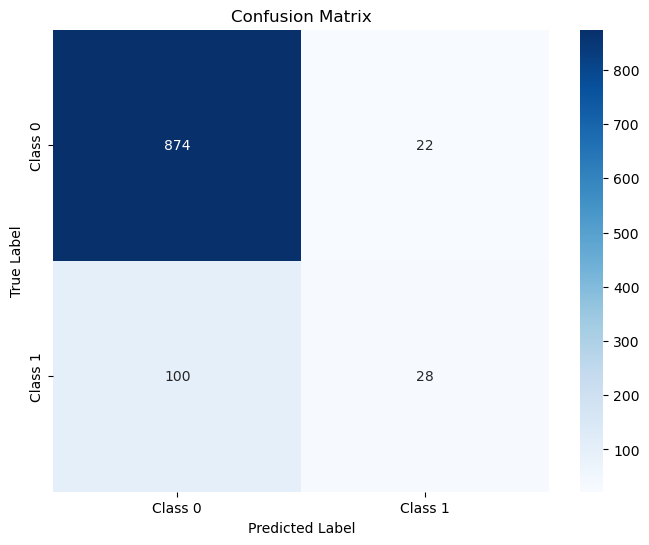

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_test_labels, y_pred_labels, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.90      0.98      0.93       896
     Class 1       0.56      0.22      0.31       128

    accuracy                           0.88      1024
   macro avg       0.73      0.60      0.62      1024
weighted avg       0.86      0.88      0.86      1024



## XGBoost Model

In [22]:
import xgboost as xgb

y_train_labels = np.argmax(y_train, axis=1)
dtrain = xgb.DMatrix(features, label=y_train_labels)
dtest = xgb.DMatrix(x_test_features)

In [23]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'subsample': 0.6,
    'colsample_bytree': 0.6
}

model = xgb.train(params, dtrain, num_boost_round=100)

y_pred_prob = model.predict(dtest)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_prob]
print(classification_report(y_test_labels, y_pred))
f1_score(y_test_labels, y_pred, average='weighted')

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:07:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       896
           1       0.50      0.09      0.15       128

    accuracy                           0.88      1024
   macro avg       0.69      0.54      0.54      1024
weighted avg       0.84      0.88      0.83      1024



0.8343238496663155

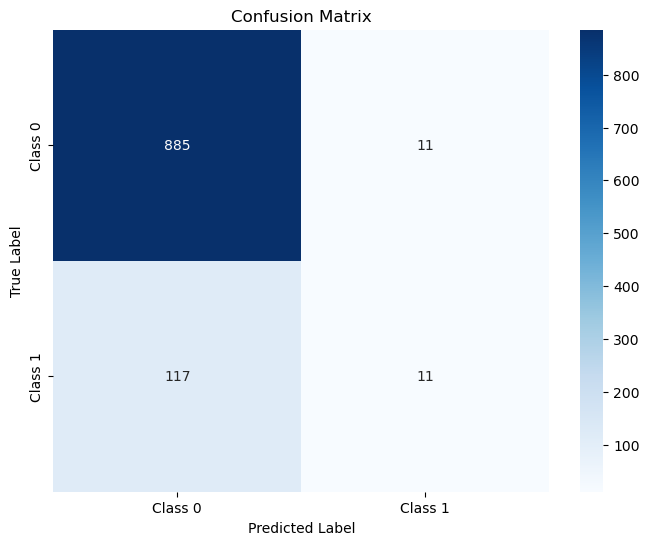

In [24]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 2-Layer FFN

Epoch 1/30
120/120 [==============================] - 1s 3ms/step - loss: 0.6704 - accuracy: 0.6452 - val_loss: 0.3486 - val_accuracy: 0.8849
Epoch 2/30
120/120 [==============================] - 0s 2ms/step - loss: 0.4432 - accuracy: 0.7938 - val_loss: 0.2960 - val_accuracy: 0.8787
Epoch 3/30
120/120 [==============================] - 0s 2ms/step - loss: 0.3342 - accuracy: 0.8619 - val_loss: 0.2646 - val_accuracy: 0.8870
Epoch 4/30
120/120 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.8760 - val_loss: 0.2628 - val_accuracy: 0.8828
Epoch 5/30
120/120 [==============================] - 0s 2ms/step - loss: 0.2872 - accuracy: 0.8791 - val_loss: 0.2679 - val_accuracy: 0.8912
Epoch 6/30
120/120 [==============================] - 0s 2ms/step - loss: 0.2725 - accuracy: 0.8844 - val_loss: 0.2572 - val_accuracy: 0.8912
Epoch 7/30
120/120 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.8864 - val_loss: 0.2569 - val_accuracy: 0.8891
Epoch 

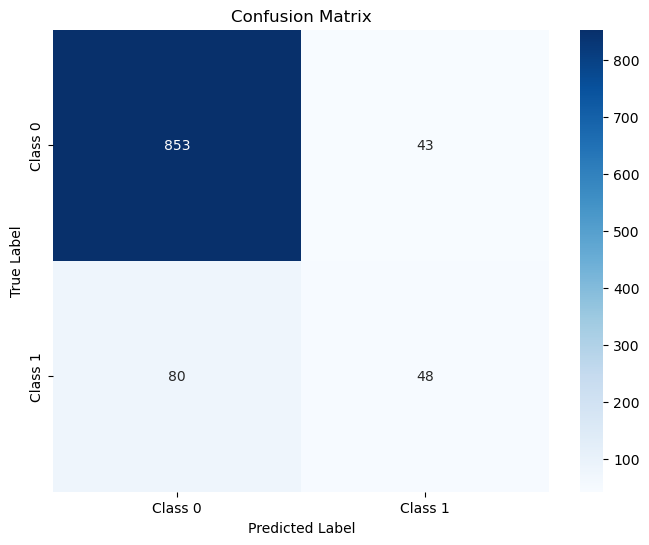

0.8709508901488201


In [25]:
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
ffnmodel = Sequential()
ffnmodel.add(Dense(128, input_dim=features.shape[1], activation='relu')) 
ffnmodel.add(Dropout(0.5)),
ffnmodel.add(BatchNormalization()),
ffnmodel.add(Dense(32, activation='relu')) 
ffnmodel.add(Dropout(0.3)),
ffnmodel.add(BatchNormalization()),
ffnmodel.add(Dense(y_train.shape[1], activation='softmax')) 

ffnmodel.compile(loss='categorical_crossentropy', 
              optimizer='adam',               
              metrics=['accuracy'])

history = ffnmodel.fit(features, y_train, epochs=30, batch_size=16, verbose=1, validation_split=0.2)

scores = ffnmodel.evaluate(x_test_features, y_test)
y_pred = ffnmodel.predict(x_test_features)

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(f1_score(y_test_labels, y_pred_labels, average='weighted'))

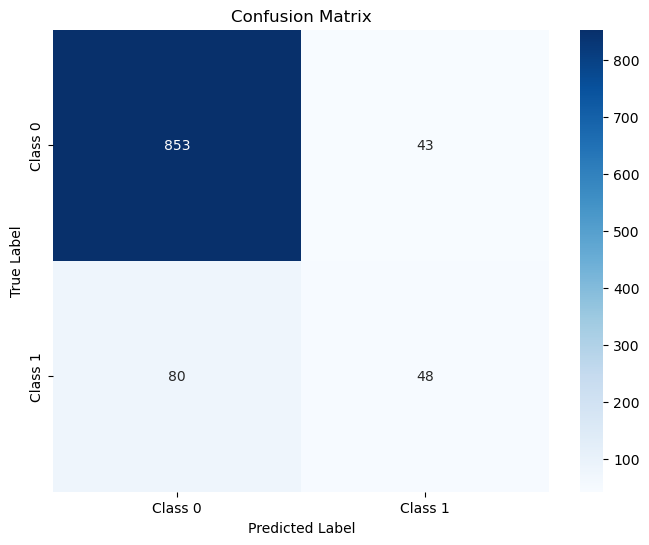

0.8709508901488201


In [28]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(f1_score(y_test_labels, y_pred_labels, average='weighted'))

## Feature Reduction Performance

In [31]:
from sklearn.decomposition import PCA

n_components = 1000

pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features)
x_test_features_pca = pca.fit_transform(x_test_features)

In [36]:
knn_model = KNeighborsClassifier(n_neighbors=4) 
knn_model.fit(features_pca, y_train)
y_pred = knn_model.predict(x_test_features_pca)
f1_score(y_test, y_pred, average='weighted')

0.8126259523224381

In [37]:
for i in range(1,20):
    knn_model = KNeighborsClassifier(n_neighbors=i) 
    knn_model.fit(features_pca, y_train)
    y_pred = knn_model.predict(x_test_features_pca)
    print(f1_score(y_test, y_pred, average='weighted'))

0.8405091692873045
0.8040642765450211
0.8248133202269475
0.8126259523224381
0.82377553531873
0.8213051743101717
0.8254039144859537
0.8192005638340717
0.8180273327838106
0.816515127132282
0.8185289163391354
0.8179805181763407
0.8203327639653317
0.8184532821240178
0.8180273327838106
0.8161189358372457
0.8156934306569343
0.8156934306569343
0.8156934306569343


In [38]:
import xgboost as xgb

y_train_labels = np.argmax(y_train, axis=1)
dtrain = xgb.DMatrix(features, label=y_train_labels)
dtest = xgb.DMatrix(x_test_features)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model = xgb.train(params, dtrain, num_boost_round=100)

y_pred_prob = model.predict(dtest)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_prob]

f1_score(y_test_labels, y_pred, average='weighted')

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


0.8407667913481867

## Hyperparameter Tuning

In [229]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(50, 201),
    'subsample': uniform(0.6, 0.4),  
    'colsample_bytree': uniform(0.6, 0.4)  
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
f1_scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, scoring=f1_scorer, cv=3)
random_search.fit(features, y_train_labels)

best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 0.8807787738117816, 'learning_rate': 0.2000518901377601, 'max_depth': 3, 'n_estimators': 151, 'subsample': 0.7039138165593433}


In [39]:
best_params = {'colsample_bytree': 0.8807787738117816, 'learning_rate': 0.2000518901377601, 'max_depth': 3, 'n_estimators': 151, 'subsample': 0.7039138165593433}
best_model = xgb.train(best_params, dtrain, num_boost_round=100)

y_pred_prob = best_model.predict(dtest)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_prob]

f1 = f1_score(y_test_labels, y_pred, average='weighted')
print("F1 Score:", f1)

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:12:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8528030303030303


Epoch 1/30
30/30 [==============================] - 0s 3ms/step - loss: 0.8441 - accuracy: 0.5521 - val_loss: 0.3850 - val_accuracy: 0.8326
Epoch 2/30
30/30 [==============================] - 0s 1ms/step - loss: 0.6126 - accuracy: 0.6960 - val_loss: 0.3901 - val_accuracy: 0.8661
Epoch 3/30
30/30 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.7698 - val_loss: 0.3555 - val_accuracy: 0.8787
Epoch 4/30
30/30 [==============================] - 0s 1ms/step - loss: 0.4212 - accuracy: 0.8174 - val_loss: 0.3289 - val_accuracy: 0.8828
Epoch 5/30
30/30 [==============================] - 0s 1ms/step - loss: 0.3541 - accuracy: 0.8603 - val_loss: 0.3008 - val_accuracy: 0.8849
Epoch 6/30
30/30 [==============================] - 0s 1ms/step - loss: 0.3172 - accuracy: 0.8776 - val_loss: 0.2783 - val_accuracy: 0.8870
Epoch 7/30
30/30 [==============================] - 0s 1ms/step - loss: 0.2636 - accuracy: 0.9074 - val_loss: 0.2695 - val_accuracy: 0.8933
Epoch 8/30
30/30 [==

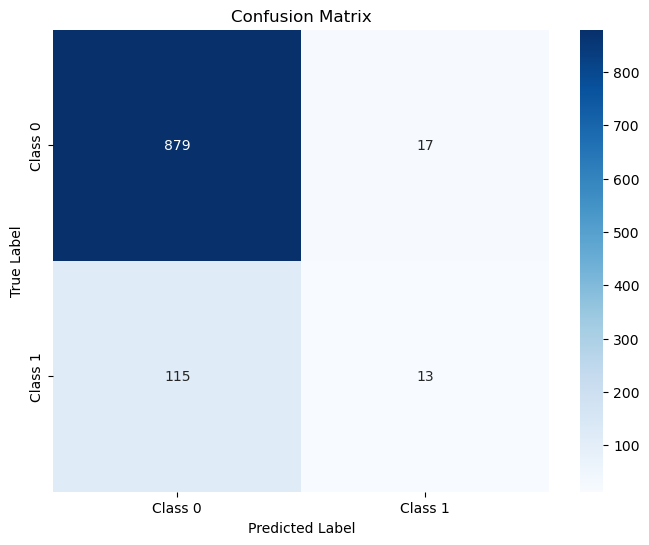

0.8344585091420533


In [43]:
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
model = Sequential()
model.add(Dense(128, input_dim=features_pca.shape[1], activation='relu')) 
model.add(Dropout(0.5)),
model.add(BatchNormalization()),
model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.3)),
model.add(BatchNormalization()),
model.add(Dense(y_train.shape[1], activation='sigmoid')) 

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',               
              metrics=['accuracy'])

history = model.fit(features_pca, y_train, epochs=30, batch_size=64, verbose=1, validation_split=0.2)

scores = model.evaluate(x_test_features_pca, y_test)
y_pred = model.predict(x_test_features_pca)

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(f1_score(y_test_labels, y_pred_labels, average='weighted'))